In [1]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import seaborn as sns

# 1. Business Questions

Below are the business questions that we are trying to answer with the Boston listings data:

**1. Which neighborhoods have high number of listings and are costly?** <br>
**2. How property type varies across neighborhood?** <br>
**3. Can we predict the price of a given listing with certain features?**

# 2. Data Understanding

In [2]:
#loading data
boston_listings = pd.read_csv('data/listings.csv')

In [3]:
#dimensions of data
print(f"There are {boston_listings.shape[0]} rows and {boston_listings.shape[1]} columns in Boston listings")

There are 3585 rows and 95 columns in Boston listings


In [4]:
boston_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,2.016090e+13,9/7/2016,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,2.016090e+13,9/7/2016,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,2.016090e+13,9/7/2016,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47


**Many columns in the data seem to be unnecessary for our study. The unwanted columns and the reasons for removing them are given below:**

The urls("thumbnail_url, medium_url, listing_url,picture_url, xl_picture_url, host_url, host_thumbnail_url, host_picture_url") 
are removed because they are just a web link and dont have any significance. host_id, name, host_name are removed for the same 
reason too.

"summary, space, description, neighborhood_overview, notes, transit, access, interaction, house_rules,  host_about" are too
verbose and we are removing them as our business questions dont need them and as we are not going to use NLP extensively.

"jurisdiction_names, license" columns dont have any value.

"country_code, country, host_location, host_neighbourhood, street, scrape_id, host_verifications"
are columns that have values that can be found in other columns as well or are not necessary to answer the business question


In [5]:
#removing unnecessary columns


cols_drops = ['thumbnail_url', 'medium_url', 'listing_url','picture_url', 'xl_picture_url', 
'host_url', 'host_thumbnail_url', 'host_picture_url','host_id',  'name',  'host_name', 'summary', 'space', 'description', 
'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules',  'host_about','jurisdiction_names', 
'license', 'country_code', 'country', 'host_location', 'host_neighbourhood', 'street', 'scrape_id', 'host_verifications',
'host_since']

In [6]:
#dataset after removing unnecessary columns
boston_listings= boston_listings.drop(cols_drops, axis=1)
boston_listings.shape

(3585, 64)

# 3. Data Preparation

In [7]:
#Drop the rows with missing response values.
boston_listings = boston_listings.dropna(subset=['price'], axis=0)


In [8]:
#Drop columns with NaN for all the rows
boston_listings = boston_listings.dropna(how='all', axis=1)

In [9]:
#Drop rows with NaN for all the columns
boston_listings = boston_listings.dropna(how='all', axis=0)

In [10]:
#Drop columns which have same values in all rows 
num_unique = boston_listings.nunique() #finding number of unique values in each column
cols_with_same_value = num_unique[num_unique == 1].index #identifying columns with same value in all rows
boston_listings = boston_listings.drop(cols_with_same_value, axis=1) #removing them

In [11]:
#dataset after removing unnecessary columns
boston_listings.shape

(3585, 57)

In [12]:
#columns with more than 75% missing values
high_missing_values = list(boston_listings.columns[boston_listings.isnull().mean()>0.75])
high_missing_values

['square_feet', 'weekly_price', 'monthly_price']

In [13]:
# dropping columns with more than 75% of missing Data as they could bring more variance
boston_listings = boston_listings.drop(high_missing_values, axis=1)
boston_listings.shape

(3585, 54)

**There are certain fields that are currency/percentage values but are present as categorical variables**

In [14]:
boston_listings[['host_response_rate', 'price']].head()

,host_response_rate,price
0,NaN,$250.00
1,100%,$65.00
2,100%,$65.00
3,100%,$75.00
4,100%,$79.00


.**These need to be converted to numerical data so as to make maximum use of them**

In [15]:
'''This function determines the currency and percentage entities 
in a dataset that are stored as categorical variables. It does it 
by looking at each categorical column to see if $ or % is present 
in all its rows
'''

def currency_percentage_entities_finder(df):
    
    '''
    INPUT
        df - the dataframe for which currency and percentage entities have to be found. 
    OUTPUT 
        dollars - The list of currency entities in df
        percentages - The list of currency entities in df
    '''
    
    cat_variables = df.select_dtypes(include=['object']).copy().columns #finding all categorical columns
    dollars = [] #initializing the list where the currency entities will be stored
    for variable in  list(cat_variables):
        flag = 0

        for i in df[variable].dropna():
            if "$" in i:
                flag+= 1
        if flag == df[variable].dropna().shape[0]: #if all the values in a column contain $, it's added to the list   
            dollars.append(variable)
            
            
    percentages = [] #initializing the list where the percentage entities will be stored
    for variable in  list(cat_variables):
        flag = 0

        for i in df[variable].dropna():
            if "%" in i:
                flag+= 1
        if flag == df[variable].dropna().shape[0]:  ##if all the values in a column contain %, it's added to the list  
            percentages.append(variable)
            
    return dollars, percentages

In [16]:
#finding the currency and percentage entities in boston_listings
currency_entities, percentage_entities = currency_percentage_entities_finder(boston_listings)

In [17]:
#printing the identified entities
print(f"Currency Entities:{currency_entities}, \nPercentage Entities:{percentage_entities}")

Currency Entities:['price', 'security_deposit', 'cleaning_fee', 'extra_people'], 
Percentage Entities:['host_response_rate', 'host_acceptance_rate']


In [18]:
#converting currency/percentage entities from str to float after removing $/% symbols
for col in currency_entities:
    boston_listings[col] = boston_listings[col].replace('[\$,]', '', regex=True).astype(float)
    
for col in percentage_entities:
    boston_listings[col] = boston_listings[col].replace('[%,]', '', regex=True).astype(float)

In [19]:
'''
The amenities column has many values separated by comma
in a single cell, which would make it difficult to use it. 
Also, there are special characters('{,},"') in the values.
'''
boston_listings["amenities"].head()

0    {TV,"Wireless Internet",Kitchen,"Free Parking ...
1    {TV,Internet,"Wireless Internet","Air Conditio...
2    {TV,"Cable TV","Wireless Internet","Air Condit...
3    {TV,Internet,"Wireless Internet","Air Conditio...
4    {Internet,"Wireless Internet","Air Conditionin...
Name: amenities, dtype: object

In [20]:
'''
The below code cleans the special characters('{,},"')
from the column, creates as many columns as there are
unique ameneties in dataset and fills those columns
with 1/0 depending on whether the amenities are present 
or not in every listing. 

'''

def clean_specialcharacters(column):
    '''
    INPUT
         column - The column(amenities) in which there are special characters and several values are separated by "," 
    OUTPUT
         cleaned_column - The input column cleaned and the values separated and stored in a list in each cell
         amenities_unique - List of ameneties extracted from the column
    '''
    cleaned_column = column.apply(lambda x:x.replace('"', '').replace('{', '').replace('}', '').split(","))
    amenities_unique = list(pd.Series([x for _list in cleaned_column for x in _list]).unique())
    return cleaned_column, amenities_unique



In [21]:
'''
Converting the ameneties column into a list form after removing the special characters and getting the list 
of unique ameneties in the column
'''
boston_listings["amenities"], amenities_unique = clean_specialcharacters(boston_listings["amenities"])
print(f"List of unique ameneties:{amenities_unique}\n\n")

print(f"Number of unique ameneties:{len(amenities_unique)}\n\n")


print(f"Converted ameneties column format:")
print(boston_listings["amenities"].head())






List of unique ameneties:['TV', 'Wireless Internet', 'Kitchen', 'Free Parking on Premises', 'Pets live on this property', 'Dog(s)', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Smoke Detector', 'Fire Extinguisher', 'Essentials', 'Shampoo', 'Laptop Friendly Workspace', 'Internet', 'Air Conditioning', 'Pets Allowed', 'Carbon Monoxide Detector', 'Lock on Bedroom Door', 'Hangers', 'Hair Dryer', 'Iron', 'Cable TV', 'First Aid Kit', 'Safety Card', 'translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50', 'Gym', 'Breakfast', 'Indoor Fireplace', 'Cat(s)', '24-Hour Check-in', 'Hot Tub', 'Buzzer/Wireless Intercom', 'Other pet(s)', 'Washer / Dryer', 'Smoking Allowed', '', 'Suitable for Events', 'Wheelchair Accessible', 'Elevator in Building', 'Pool', 'Doorman', 'Paid Parking Off Premises', 'Free Parking on Street']


Number of unique ameneties:46


Converted ameneties column format:
0    [TV, Wireless Internet, Kitchen, Free Parking ...
1    [TV, Interne

In [22]:
'''
Creating separate columns for each amenity in the dataset and encoding them with 0,1 for each listing 
based on whether the corresponding amenity is present in the listing or not and removing the amenity 
column from the dataset
'''
for i in amenities_unique:
    boston_listings[i] = pd.Series(np.random.randn(3585), index=boston_listings.index)   
    boston_listings[i] = boston_listings["amenities"].apply(lambda x: 1 if i in x else 0)
    
boston_listings = boston_listings.drop("amenities", axis=1)
boston_listings.shape

boston_listings[amenities_unique].head()

,TV,Wireless Internet,Kitchen,Free Parking on Premises,Pets live on this property,Dog(s),Heating,Family/Kid Friendly,Washer,Dryer,...,Washer / Dryer,Smoking Allowed,,Suitable for Events,Wheelchair Accessible,Elevator in Building,Pool,Doorman,Paid Parking Off Premises,Free Parking on Street
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Above are the 46 columns that are created for each amenity and the corresponding values 0/1 are filled based on their availabilty for each listing.**

# 4. Modeling

# 1. Which neighborhoods have high number of listings and are costly?

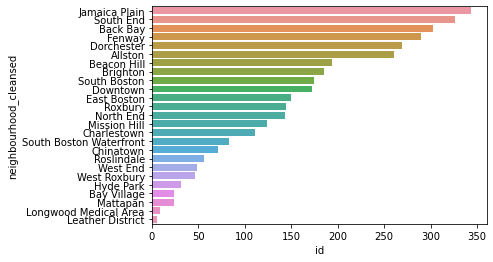

In [23]:
#Plotting the number of listings in each neighborhood in descending order


neighborhood_count = boston_listings[['neighbourhood_cleansed','id']].groupby(by =["neighbourhood_cleansed"]).count().sort_values(by=['id'], ascending=False).reset_index()
ax1 = sns.barplot(x="id", y="neighbourhood_cleansed", data=neighborhood_count)

**Jamaica Plain, South End, Back Bay, Fenway, Dorchester are the neighborhood with maximum listings.**

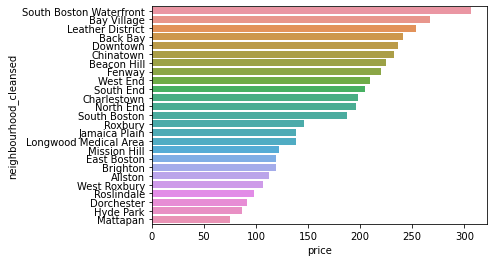

In [24]:
#Plotting the average price of listings in each neighborhood in descending order
neighborhood_price = boston_listings[['neighbourhood_cleansed','price']].groupby(by =["neighbourhood_cleansed"]).mean().sort_values(by=['price'], ascending=False).reset_index()
ax2 = sns.barplot(x="price", y="neighbourhood_cleansed", data=neighborhood_price)

**Leather District, South Boston Waterfront, Chinatown, Downtown, Back Bay neighborhoods on an average have listings that are costlier than other.**

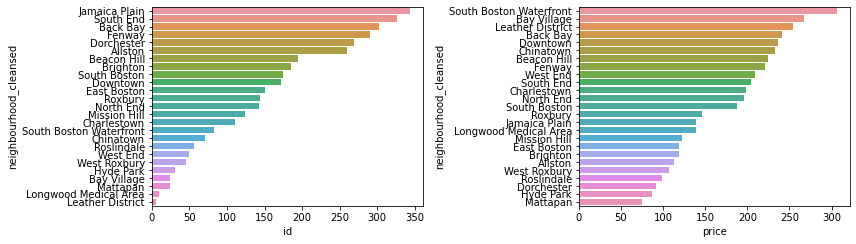

In [25]:
#Plotting the two above figures side by side for comparison
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [12.00, 3.50]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)
sns.barplot(x="id", y="neighbourhood_cleansed", data=neighborhood_count,ax=axes[0])
sns.barplot(x="price", y="neighbourhood_cleansed", data=neighborhood_price,ax=axes[1])
plt.show()

**Neighborhoods like South Boston Waterfront, Bay Village, Back Bay, Downtown, Chinatown seem to be posh areas as they are costlier compared to other neighborhoods. <br> 
Neighborhoods like Mattapan, Hyde Park, Rosindale are cheap, but have only few properties to choose from. <br>
Dorchester, Allston, Brighton are some neighborhoods, which are relatively cheap, with a lot of listings to choose from.**

# 2. How property type varies across neighborhood?

room_type   neighbourhood_cleansed  Entire home/apt  Private room  Shared room
0                          Allston             98.0         156.0          6.0
1                         Back Bay            263.0          36.0          3.0
2                      Bay Village             20.0           4.0          NaN
3                      Beacon Hill            155.0          36.0          3.0
4                         Brighton             75.0         103.0          7.0
5                      Charlestown             68.0          42.0          1.0
6                        Chinatown             62.0           8.0          1.0
7                       Dorchester             66.0         195.0          8.0
8                         Downtown            144.0          24.0          4.0
9                      East Boston             70.0          77.0          3.0
10                          Fenway            208.0          73.0          9.0
11                       Hyde Park              6.0 

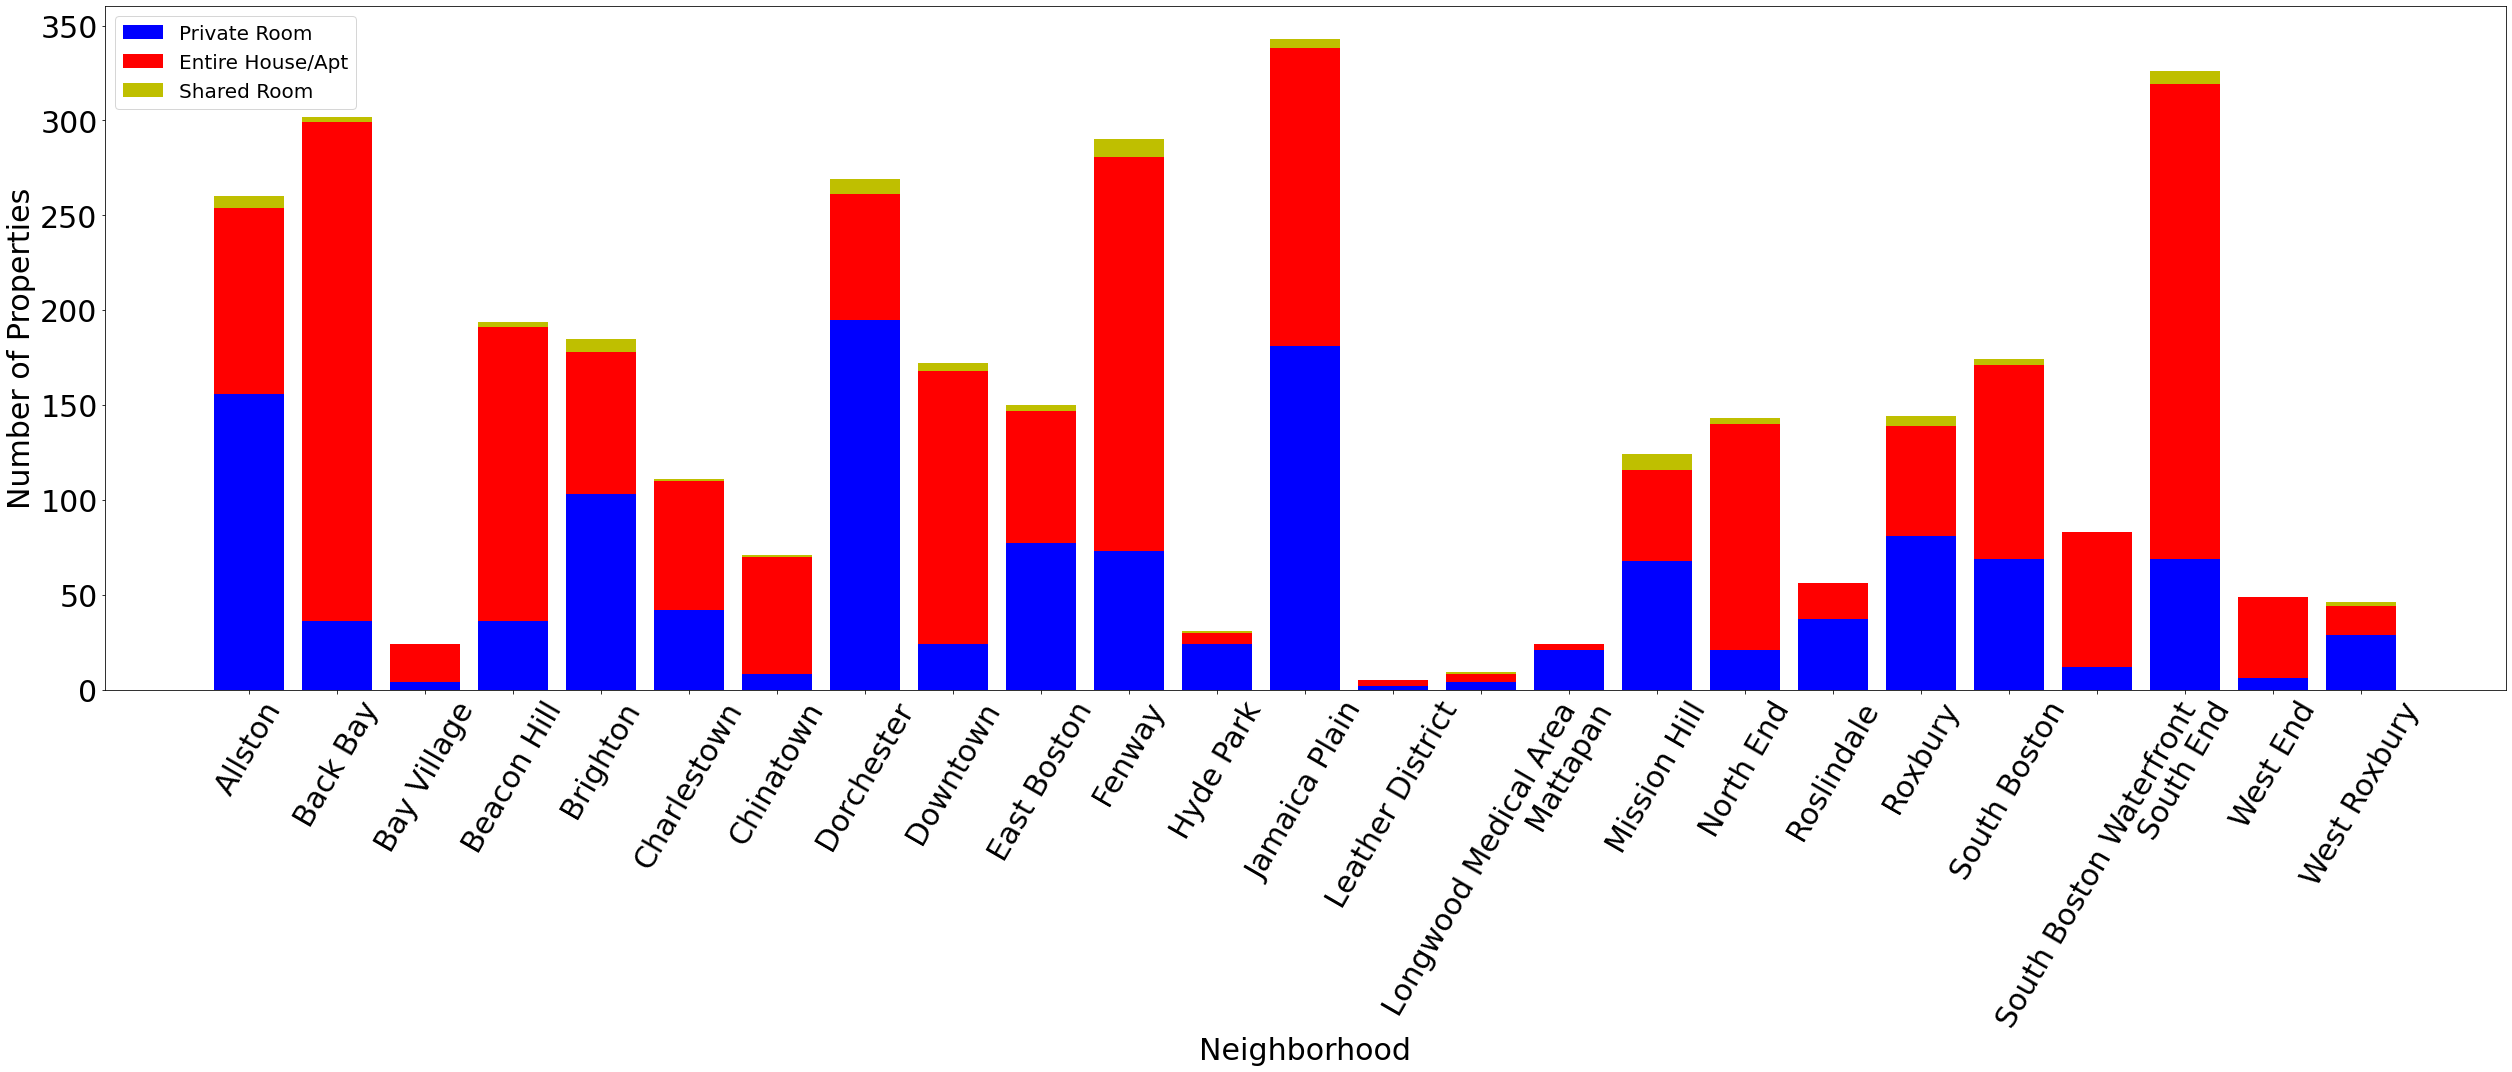

In [26]:
#Neigbourhood by room type
neighborhood_room_type = boston_listings[['neighbourhood_cleansed','room_type']].value_counts().reset_index()
neighborhood_room_type = neighborhood_room_type.rename(columns={0: 'number_of_rooms'})
neighborhood_room_type.head()
pivot_table = neighborhood_room_type.pivot(index='neighbourhood_cleansed', columns='room_type', values='number_of_rooms').reset_index()
print(pivot_table)

plt.rcParams["figure.figsize"] = [35.00, 15]
plt.rcParams["figure.autolayout"] = True
plt.xticks(rotation=60,fontsize = 30)
plt.yticks(fontsize = 30)

plt.bar(pivot_table['neighbourhood_cleansed'], pivot_table['Private room'],  color='b')
plt.bar( pivot_table['neighbourhood_cleansed'],pivot_table['Entire home/apt'],bottom=pivot_table['Private room'],color='r')
plt.bar(pivot_table['neighbourhood_cleansed'],pivot_table['Shared room'],bottom=pivot_table['Private room']+pivot_table['Entire home/apt'],color='y')
plt.xlabel("Neighborhood",fontsize = 30)
plt.ylabel("Number of Properties",fontsize = 30)
plt.legend(["Private Room", "Entire House/Apt", "Shared Room"], fontsize = 20)
plt.show()


**The study of property types across neighborhood gives the below insights on the neighborhoods that were discussed previously.**

1. In posh areas we discussed(like South Boston Waterfront, Bay Village, Back Bay, Downtown, Chinatown) majority of the listings are Entire house/apt, with a few Private rooms and very few Shared Rooms.   
2. Neighborhoods like Mattapan, Hyde Park, Rosindale that are cheap have more Private rooms and few Entire houses/apts. 
3. Dorchester, Allston, Brighton are some neighborhoods, which are relatively cheap, have more Private rooms than other types, but have good number of Entire houses/apts too to choose from.


# 3. Can we predict the price of a given listing with certain features?

**A. Selecting categorical features** <br>
<br>
The categorical features should first be converted to numeric by encoding

In [27]:
#Finding the category columns and creating dummy columns for them to make them numerical
cat_vars = boston_listings.select_dtypes(include=['object']).copy().columns #finding the list of categorical columns



In [28]:
'''
creating a dataframe 'cat_df' that converts the categorical columns 
to numerical with 0,1 encodings and deletes the original columns. 
'''
cat_df = boston_listings[cat_vars]
for col in list(cat_vars):
    
    cat_df = pd.concat([pd.get_dummies(cat_df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False), cat_df.drop(col, axis=1)], axis=1)

In [29]:
#shape of cat_df
cat_df.shape  

(3585, 1618)

**There are 1618 columns that are created from the categorical columns. As the number of columns is too much, we are selecting the top 30 in them that correlate best with price**

In [30]:
#Selecting the top 30 categorical columns that correlate with price
cat_df = pd.concat([cat_df,boston_listings['price']], axis=1)
top_cat_select = cat_df.corr()['price'].abs().sort_values(ascending=False)[:30]
selected_cat_var = cat_df[top_cat_select.index]

selected_cat_var.columns

Index(['price', 'room_type_Private room', 'neighbourhood_cleansed_Dorchester',
       'cancellation_policy_super_strict_30', 'neighbourhood_Back Bay',
       'zipcode_2210', 'neighbourhood_cleansed_South Boston Waterfront',
       'neighbourhood_cleansed_Back Bay', 'require_guest_phone_verification_t',
       'zipcode_2116', 'neighbourhood_Dorchester', 'property_type_House',
       'zipcode_2134', 'bed_type_Real Bed', 'neighbourhood_Fenway/Kenmore',
       'zipcode_2125', 'neighbourhood_South Boston',
       'neighbourhood_cleansed_Downtown', 'zipcode_2124',
       'neighbourhood_cleansed_Fenway', 'zipcode_2215', 'zipcode_2111',
       'neighbourhood_cleansed_Brighton', 'cancellation_policy_strict',
       'room_type_Shared room', 'neighbourhood_cleansed_Beacon Hill',
       'zipcode_2135', 'zipcode_2118', 'city_Boston',
       'smart_location_Boston, MA'],
      dtype='object')

**B. Selecting numerical features**

In [31]:
#Finding the numerical columns in the listing dataset
numerical_vars = boston_listings.select_dtypes(include=['float', 'int']).columns
numerical_vars

Index(['id', 'host_response_rate', 'host_acceptance_rate',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'TV', 'Wireless Internet', 'Kitchen',
       'Free Parking on Premises', 'Pets live on this property', 'Dog(s)',
       'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Smoke Detector',
       'Fire Extinguisher', 'Essentials', 'Shampoo',
       'Laptop Friendly Workspace', 'Internet', 

In [32]:
#number of numerical columns
len(numerical_vars)

78

**As the number of columns is high, we are selecting the top 20 in them that correlate best with price**

In [33]:
#Selecting the top 20 numerical columns that correlate with price
top_num_select = boston_listings.corr()['price'].abs().sort_values(ascending=False)[:20]
selected_num_var = boston_listings[top_num_select.index]

selected_num_var.columns

Index(['price', 'cleaning_fee', 'accommodates', 'bedrooms', 'beds',
       'security_deposit', 'bathrooms', 'TV', 'Cable TV',
       'Family/Kid Friendly', 'Elevator in Building', 'Air Conditioning',
       'guests_included', 'latitude', 'review_scores_location', 'Gym',
       'Doorman', 'host_total_listings_count', 'host_listings_count',
       'longitude'],
      dtype='object')

**C. Imputing missing values**

In [34]:
# Fill NULL values in numeric columns with the mean

for col in selected_num_var.columns:
    selected_num_var[col].fillna((selected_num_var[col].mean()), inplace=True)
selected_num_var.columns

C:\Users\2304536\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


Index(['price', 'cleaning_fee', 'accommodates', 'bedrooms', 'beds',
       'security_deposit', 'bathrooms', 'TV', 'Cable TV',
       'Family/Kid Friendly', 'Elevator in Building', 'Air Conditioning',
       'guests_included', 'latitude', 'review_scores_location', 'Gym',
       'Doorman', 'host_total_listings_count', 'host_listings_count',
       'longitude'],
      dtype='object')

In [35]:
#Combining numerical and categorical data converted to numerical to form the final features. 
X  = pd.concat([selected_num_var.drop('price',axis=1),selected_cat_var.drop('price',axis=1)],axis=1)

X.head()

,cleaning_fee,accommodates,bedrooms,beds,security_deposit,bathrooms,TV,Cable TV,Family/Kid Friendly,Elevator in Building,...,zipcode_2215,zipcode_2111,neighbourhood_cleansed_Brighton,cancellation_policy_strict,room_type_Shared room,neighbourhood_cleansed_Beacon Hill,zipcode_2135,zipcode_2118,city_Boston,"smart_location_Boston, MA"
0,35.000000,4,2.0,3.0,324.698212,1.5,1,0,1,0,...,0,0,0,0,0,0,0,0,1,1
1,10.000000,2,1.0,1.0,95.000000,1.0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,1
2,68.380145,2,1.0,1.0,324.698212,1.0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,50.000000,4,1.0,2.0,100.000000,1.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,15.000000,2,1.0,2.0,324.698212,1.5,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [36]:
y = boston_listings['price']

**D. Building and Evaluating the model**

1. Train test split
2. Training the Linear Regression model using training data
3. Predicting the test test and calculating the score

Linear regression is used to keep the model simple and to check how much of the variablility is explained by the model.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42 )

reg = LinearRegression(normalize = True)


reg.fit(X_train, y_train)
prediction = reg.predict(X_test)
from sklearn.metrics import r2_score
r2_score(y_test, prediction)


0.28828346784093684

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

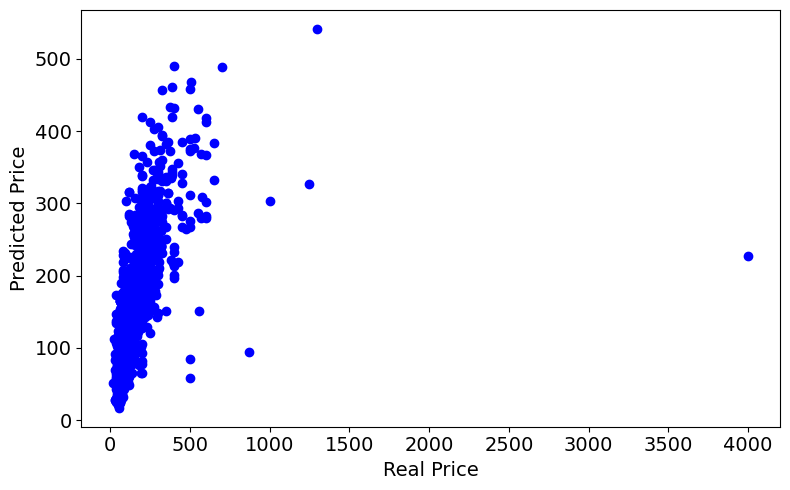

In [38]:
fig = plt.figure(figsize =(8, 5),dpi=100)
plt.scatter(y_test, prediction, color='blue')
plt.xlabel('Real Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


The score seems to be very low(only 29%) for the testing set. 

In [39]:
#Calculating the score for the training set
prediction_train = reg.predict(X_train)
r2_score(y_train, prediction_train)


0.43535537229003296

In [40]:
#Looking at the summary statistics for price
y.describe()

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

price seems to take values as low as 10 to as high as 4000

**D. Removing Outliers**

Text(0, 0.5, 'Price')

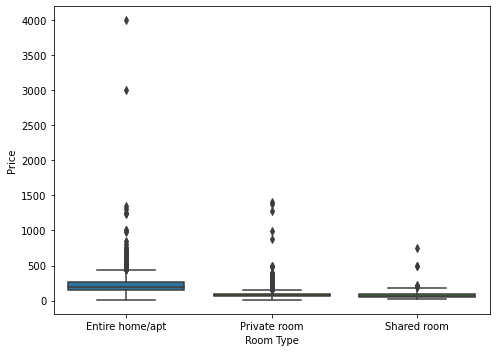

In [41]:
# Plotting boxplot for all room types
figure,ax = plt.subplots(figsize=(7,5))
sns.boxplot(x="room_type",y="price",data=boston_listings)
plt.xlabel('Room Type')
plt.ylabel('Price')


There are outliers for all room types. We are going to eliminate the outliers by calculating the inter quartile range(IQR). 
Listings with prices below Q1-(IQR*1.5) and above Q3+(IQR*1.5) will be removed from the study 

In [42]:
#Finding the range for outliers
regression_final_dataset   = pd.concat([X,y],axis=1)
Q1 = np.percentile(regression_final_dataset.price,25)
Q3 = np.percentile(regression_final_dataset.price,75)
IQR = Q3-Q1
lower_bound = Q1-(IQR*1.5)
upper_bound = Q3+(IQR*1.5)

In [43]:
#Filtering out outliers from the dataset
regression_final_dataset = regression_final_dataset.loc[regression_final_dataset['price'] >= lower_bound]
regression_final_dataset = regression_final_dataset.loc[regression_final_dataset['price'] <= upper_bound]

In [44]:
X = regression_final_dataset.drop('price',axis=1)
y = regression_final_dataset['price']

**E. Final Evaluation**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42 )

reg = LinearRegression(normalize = True)


reg.fit(X_train, y_train)
prediction = reg.predict(X_test)
from sklearn.metrics import r2_score
r2_score(y_test, prediction)


0.6774237162645733

After removing the outliers, the score has improved to 68%. 

**F. Visualization**

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

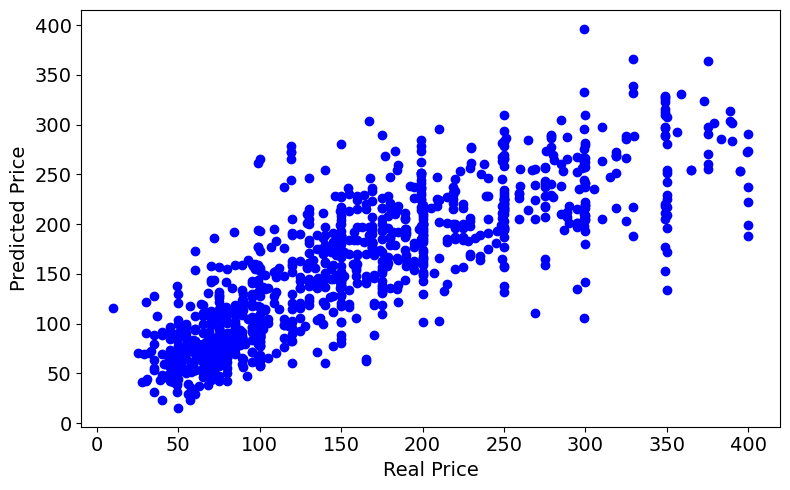

In [46]:
fig = plt.figure(figsize =(8, 5),dpi=100)
plt.scatter(y_test, prediction, color='blue')
plt.xlabel('Real Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


There seems to be very good correlation between Predicted and Real price now. 